# Data Exploration and Preprocessing
TCGA Reannotated Ovarian Cancer Clinical Data 

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from openpyxl import load_workbook
import sidetable
from functools import reduce
import itertools
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cpu')

Import Data

In [280]:
# Villalobos 2018 reannotated TCGA data (https://ascopubs.org/doi/suppl/10.1200/CCI.17.00096)
tcga_ov_1 = pd.read_excel('./Data/Villalobos_TCGA/ds_CCI.17.00096-1.xlsx',
                          sheet_name='Master clinical dataset'
                          )

tcga_ov_2 = pd.read_excel('./Data/Villalobos_TCGA/ds_CCI.17.00096-2.xlsx',
                          sheet_name='Months'
                          )

tcga_ov_3 = pd.read_excel('./Data/Villalobos_TCGA/ds_CCI.17.00096-3.xlsx',
                          sheet_name='clinical_drug_all_OV.txt'
                          )

# TCGA Drug standardization (https://gdisc.bme.gatech.edu/cgi-bin/gdisc/tap5.cgi#)
drugs = pd.read_csv('./Data/DrugCorrection1.csv')
drugs['Correction'] = drugs['Correction'].str.strip()

## Clean and Reorganize

TCGA 3: Clean

In [281]:
# Drop columns with all missing values
print(tcga_ov_3.shape)
print(tcga_ov_3.isnull().sum(), '\n')
tcga_ov_3_drop = tcga_ov_3.dropna(axis=1, how='all')
# Drop rows where drug is missing
tcga_ov_3_drop = tcga_ov_3_drop[tcga_ov_3_drop['drug_name'].notna()]
# Drop rows where start AND end are missing (right now it's actually OR, see below)
tcga_ov_3_drop = tcga_ov_3_drop.dropna(how='any', subset=['days_to_drug_therapy_end', 'days_to_drug_therapy_start']) #change to how='all' when figure out what to do with start OR end missing

# Standardize drug names
    # Merge using values from TCGA drug standardization (https://gdisc.bme.gatech.edu/cgi-bin/gdisc/tap5.cgi)
tcga_ov_3_clean = tcga_ov_3_drop.merge(drugs, how='left', left_on='drug_name', right_on='OldName').drop(['OldName'], axis=1)
    # Additional replacement rules
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Doxoribicin', 'Correction'] = 'Doxorubicin'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'gemcitabin', 'Correction'] = 'Gemcitabine'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Hexlalen', 'Correction'] = 'Altretamine'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Cisplatin/Gemzar', 'Correction'] = 'Cisplatin' # This applies to only one line, which has another sample just for Gemzar (Gemcitabine)
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Ilex', 'Correction'] = 'Ilex'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'ILIZ', 'Correction'] = 'ILIZ'
tcga_ov_3_clean.loc[tcga_ov_3_clean['drug_name'] == 'Lily', 'Correction'] = 'Lily'

    # Print replacement rules and replace 'drug_name'
drug_name_old = tcga_ov_3_clean['drug_name']
drug_name_new = tcga_ov_3_clean['Correction']
rules = pd.DataFrame({'drug_name_old': drug_name_old, 'drug_name_new': drug_name_new}).drop_duplicates().sort_values(by=['drug_name_old']).reset_index().drop('index', axis=1)

pd.set_option('display.max_rows', None)
print('Replacement Rules:\n', rules.head(), '\n')
pd.reset_option('max_rows')

tcga_ov_3_clean['drug_name'] = tcga_ov_3_clean['Correction']
tcga_ov_3_clean = tcga_ov_3_clean.drop('Correction', axis=1)

    # List of drugs in dataset
drug_list = [x for x in list(tcga_ov_3_clean['drug_name'].drop_duplicates()) if str(x) != 'nan']
drug_list.sort()
print('Unique Drugs:', len(drug_list), '\n', drug_list, '\n')

# Drop where therapy start = therapy end
tcga_ov_3_clean = tcga_ov_3_clean[tcga_ov_3_clean['days_to_drug_therapy_end'] != tcga_ov_3_clean['days_to_drug_therapy_start']] 

(2463, 19)
bcr_patient_barcode                 0
bcr_drug_barcode                    0
days_to_drug_therapy_end          339
days_to_drug_therapy_start        145
days_to_drug_treatment_end       2463
days_to_drug_treatment_start     2463
dosage_units                     2463
drug_category                       0
drug_dosage                      2463
drug_name                          11
initial_course                   2463
number_cycles                     391
regimen_indication                  2
regimen_indication_notes         2328
route_of_administration           243
route_of_administration_notes    2126
therapy_ongoing                   167
total_dose                        746
total_dose_units                  715
dtype: int64 

Replacement Rules:
            drug_name_old            drug_name_new
0         5F4 Leucovorin  Fluorouracil+Leucovorin
1            90Y-HU3S193                  Hu3S193
2                AMG 706                Motesanib
3  Abagovomab or Placebo        

TCGA 3: Fix/standardize time variables and fix order of therapy lines

In [282]:
# Fix values where start and end are switched
tcga_ov_3_clean.loc[tcga_ov_3_clean['days_to_drug_therapy_start'] > tcga_ov_3_clean['days_to_drug_therapy_end'], ['days_to_drug_therapy_start', 'days_to_drug_therapy_end']] = tcga_ov_3_clean.loc[tcga_ov_3_clean['days_to_drug_therapy_start'] > tcga_ov_3_clean['days_to_drug_therapy_end'], ['days_to_drug_therapy_end', 'days_to_drug_therapy_start']].values

# Set earliest drug therapy start to zero and subtract everything else by min days
ther_start = tcga_ov_3_clean.groupby('bcr_patient_barcode')['days_to_drug_therapy_start']
tcga_timefix = tcga_ov_3_clean.assign(start_day=ther_start.transform(min))
      # keep start days for later use with tcga_ov_1
tcga_start_days = tcga_timefix[['bcr_patient_barcode', 'start_day']].drop_duplicates()

tcga_timefix['therapy_start'] = tcga_timefix['days_to_drug_therapy_start'] - tcga_timefix['start_day']
tcga_timefix['therapy_end'] = tcga_timefix['days_to_drug_therapy_end'] - tcga_timefix['start_day']
tcga_timefix = tcga_timefix.drop(['days_to_drug_therapy_end', 'days_to_drug_therapy_start', 'start_day'], axis=1)
tcga_timefix = tcga_timefix.sort_values(by=['bcr_patient_barcode', 'therapy_start', 'therapy_end'])

# Set up state list for each patient: barcode, timing, drug combo
tcga_drug_lines = []
for barcode in tcga_timefix['bcr_patient_barcode'].unique():
    tcga_time = tcga_timefix[tcga_timefix['bcr_patient_barcode'] == barcode]
    tcga_time = tcga_time[['therapy_start', 'therapy_end', 'drug_name']].drop_duplicates(keep='first').values.tolist() # Drop duplicate drugs that have different dosages or administration but same timing

    points = [] # list of (offset, plus/minus, drug) tuples
    for start,stop,drug in tcga_time:
        points.append((start,'+',drug))
        points.append((stop,'-',drug))
    points.sort()

    ranges = [] # output list of (start, stop, drug_set) tuples
    current_set = []
    last_start = None
    for offset,pm,drug in points:
        if pm == '+':
            if last_start is not None:
                ranges.append([last_start,offset,list(set(current_set.copy()))])
            current_set.append(drug)
            last_start = offset
        elif pm == '-':
            ranges.append([last_start,offset,list(set(current_set.copy()))])
            current_set.remove(drug)
            last_start = offset

    # Finish off
    if last_start is not None:
        ranges.append([last_start,offset,list(set(current_set.copy()))])

    # Remove the ranges where start = stop
    range_drug = []
    for i in range(len(ranges)):
        if ranges[i][0] != ranges[i][1]: # add condition:  <& (ranges[i][2] != [])> to drop no-drug periods
            range_drug.append(ranges[i])

    # Sort drugs in each drug combo
    for i in range(len(range_drug)):
        range_drug[i][2].sort()

    # Remove overlapping/back-to-back duplicate lines. Drop this section if decide to do something with dosages
    ranges_final = []
    for line in range(0, len(range_drug)-1):
        if (range_drug[line+1][2] == range_drug[line][2]) & (range_drug[line+1][0] <= range_drug[line][1]):
            range_drug[line][1] = range_drug[line+1][1]
            range_drug[line+1][0] = range_drug[line][0]
        if (range_drug[line][2] != range_drug[line+1][2]) | (range_drug[line][0] != range_drug[line+1][0]):
            ranges_final.append(range_drug[line])
    ranges_final.append(range_drug[len(range_drug)-1])

    # Add the number of previous lines of therapy
    for line in range(len(ranges_final)):
        if line == 0:
            ranges_final[line].append(0) 
        elif ranges_final[line-1][2] == []:
            ranges_final[line].append(ranges_final[line-1][3])
        else:
            ranges_final[line].append(ranges_final[line-1][3] + 1)
    
    # Add treat transition var
    for line in range(len(ranges_final)):
        try:
            if (ranges_final[line][2] != []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30))
            elif (ranges_final[line][2] != []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30) - 1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(0)
        except IndexError:
            ranges_final[line].append(0)
    
    # Add no treat transition var
    for line in range(len(ranges_final)):
        try:
            if (ranges_final[line][2] != []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(0)                
            elif (ranges_final[line][2] != []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] != []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30) - 1)
            elif (ranges_final[line][2] == []) & (ranges_final[line+1][2] == []):
                ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30))
        except IndexError:
            ranges_final[line].append(math.ceil((ranges_final[line][1] - ranges_final[line][0]) / 30)-1)

    # Add patient barcodes
    for line in range(len(ranges_final)):
        ranges_final[line].insert(0, barcode)
    

    tcga_drug_lines.extend(ranges_final)

tcga_drug_lines[3] = ['TCGA-04-1332', 0.0, 151.0, ['Carboplatin', 'Paclitaxel', 'Topotecan'], 0, 5, 1] # Special case to fix. Make sure to check this if make changes above

# Back to df
lines_df = pd.DataFrame(tcga_drug_lines, columns=['bcr_patient_barcode', 'start', 'end', 'therapy', 'previous_lines', 'treat', 'no_treat'])

# List of patient barcodes
tcga_barcodes = list(lines_df['bcr_patient_barcode'].unique())

# Notes
    # One thing to be aware of is that this code drops all values where therapy start and therapy end are equal
    # Fix: drops all back to back duplicate treatment, should keep first (see TCGA-04-1365)
        #####################################I think this was fixed, but need to double check

TCGA 1: Clean

In [283]:
# Keep subset of variables 
print('NaNs: ', tcga_ov_1.isnull().sum())
tcga_ov_1_keep = tcga_ov_1[['bcr_patient_barcode',
                            'total_days_overall_survival',
                            'outcome_overall_survival_censoring',
                            # 'vital_status',
                            # 'days_to_tumor_progression',
                            # 'days_to_death',
                            # 'days_to_last_followup',
                            # 'days_to_tumor_recurrence',
                            # 'time_to_failure',  
                            # 'Cycles_of_adjuvant_therapy',
                            # 'Adjuvant_chemotherapy_dose_intensity',
                            'age_at_initial_pathologic_diagnosis',
                            # 'anatomic_organ_subdivision',
                            # 'days_to_birth',
                            # 'initial_pathologic_diagnosis_method',
                            # 'person_neoplasm_cancer_status',
                            # 'pretreatment_history',
                            # 'primary_therapy_outcome_success', # ask EKO about this
                            'race',
                            # 'residual_tumor',
                            # 'site_of_tumor_first_recurrence',
                            # 'tissue_source_site',
                            'tumor_grade',
                            # 'tumor_residual_disease',
                            'tumor_stage',
                            # 'tumor_tissue_site'
                            # 'year_of_initial_pathologic_diagnosis',
                            # 'Days off platinum prior to recurrence 1st line',
                            # 'Last day of platinum 1st line',
                            # 'Chemotherapy number of lines of therapy'
                            ]]

# Drop cases that don't have a survival metric
tcga_ov_1_keep = tcga_ov_1_keep.dropna(subset=['total_days_overall_survival'])
tcga_ov_1_keep.drop(tcga_ov_1_keep[tcga_ov_1_keep['total_days_overall_survival'] == 'cannot assess'].index, inplace=True)

# Only keep samples that are in the cleaned 'lines' data
tcga_ov_1_keep = tcga_ov_1_keep[tcga_ov_1_keep['bcr_patient_barcode'].isin(tcga_barcodes)].sort_values(by=['bcr_patient_barcode']).reset_index().drop('index', axis=1)

# Adjust final survival by start of therapy day
tcga_start_days = tcga_start_days[tcga_start_days['bcr_patient_barcode'].isin(tcga_barcodes)].sort_values(by=['bcr_patient_barcode']).reset_index().drop('index', axis=1)
tcga_ov_1_keep['total_days_overall_survival'] = tcga_ov_1_keep['total_days_overall_survival'] - tcga_start_days['start_day'] # this needs work, getting some negative values

# Fill blanks
tcga_ov_1_keep = tcga_ov_1_keep.replace(r'^\s*$', np.nan, regex=True)
tcga_ov_1_keep = tcga_ov_1_keep.replace(np.nan, 'NOT SPECIFIED', regex=True)

tcga_ov_1_keep

NaNs:  bcr_patient_barcode                                 4
total_days_overall_survival                        28
outcome_overall_survival_censoring                 16
vital_status                                       34
days_to_tumor_progression                         570
                                                 ... 
5th_chemo_regimen_days_outcome                    524
6th_chemo_regimen_days_outcome                    552
Days off platinum prior to recurrence 1st line     99
Last day of platinum 1st line                     108
Chemotherapy number of lines of therapy            27
Length: 72, dtype: int64


,bcr_patient_barcode,total_days_overall_survival,outcome_overall_survival_censoring,age_at_initial_pathologic_diagnosis,race,tumor_grade,tumor_stage
0,TCGA-04-1331,1300.0,1,79.0,WHITE,G3,IIIC
1,TCGA-04-1332,1217.0,1,70.0,WHITE,G3,IIIC
2,TCGA-04-1336,1445.0,0,55.0,WHITE,G3,IIIB
3,TCGA-04-1338,1418.0,0,78.0,WHITE,G3,IIIC
4,TCGA-04-1342,531.0,1,80.0,WHITE,G2,IV
...,...,...,...,...,...,...,...
455,TCGA-61-2113,627.0,1,54.0,WHITE,G3,IIC
456,TCGA-61-2610,1550.0,1,61.0,WHITE,G3,IIIC
457,TCGA-61-2611,417.0,1,40.0,WHITE,G3,IIIC
458,TCGA-61-2612,173.0,1,63.0,WHITE,G3,IIIC


In [284]:
tcga_ov_1_keep.to_excel('tcga_1.xlsx')

Data summary table(s)

In [285]:
book = load_workbook('Table_1.xlsx')
book.template = False

writer = pd.ExcelWriter('Table_1.xlsx', engine='openpyxl')
writer.book = book

# Race
try:
    del book['race']
except:
    pass
tcga_ov_1_keep.stb.freq(['race']).to_excel(writer, sheet_name='race')
# Tumor grade
try:
    del book['tumor grade']
except:
    pass
tcga_ov_1_keep.stb.freq(['tumor_grade']).to_excel(writer, sheet_name='tumor grade')
# Tumor stage
try:
    del book['tumor stage']
except:
    pass
tcga_ov_1_keep.stb.freq(['tumor_stage']).to_excel(writer, sheet_name='tumor stage')
# Death
try:
    del book['death']
except:
    pass
tcga_ov_1_keep.stb.freq(['outcome_overall_survival_censoring']).to_excel(writer, sheet_name='death')
# Age
try:
    del book['age']
except:
    pass
pd.DataFrame(tcga_ov_1_keep['age_at_initial_pathologic_diagnosis'].describe()).to_excel(writer, sheet_name='age')
# Overall survival
try:
    del book['total_days_overall_survival']
except:
    pass
pd.DataFrame(tcga_ov_1_keep['total_days_overall_survival'].describe()).to_excel(writer, sheet_name='days survival')

writer.save()
writer.close()

Add death dummy to drug lines data

In [286]:
# Merge in final death event for each patient
lines_df_2 = lines_df.merge(tcga_ov_1_keep[['bcr_patient_barcode', 'outcome_overall_survival_censoring']], on='bcr_patient_barcode').rename(columns={'bcr_patient_barcode': 'patient', 'outcome_overall_survival_censoring': 'death'})

# Only keep death event on last line
lines_df_2.loc[lines_df_2['patient'] == lines_df_2['patient'].shift(-1), 'death'] = 0

# Total events
lines_df_2['total_ev'] = lines_df_2['treat'] + lines_df_2['no_treat'] + lines_df_2['death']

# Function to get indices of a therapy
def get_index_pos(my_list, val):
    return [i for i, x in enumerate(my_list) if x == val]

In [287]:
# Create version of final dataset that only includes patients who died
d_pats = list(tcga_ov_1_keep['bcr_patient_barcode'].loc[tcga_ov_1_keep['outcome_overall_survival_censoring'] == 1])

lines_df_d = lines_df_2[lines_df_2['patient'].isin(d_pats)].reset_index().drop(['index'], axis=1)
lines_df_d

,patient,start,end,therapy,previous_lines,treat,no_treat,death,total_ev
0,TCGA-04-1331,0.0,133.0,"[Carboplatin, Paclitaxel]",0,4,1,0,5
1,TCGA-04-1331,133.0,445.0,[],1,1,10,0,11
2,TCGA-04-1331,445.0,462.0,[Dortezomib],1,0,0,1,1
3,TCGA-04-1332,0.0,151.0,"[Carboplatin, Paclitaxel, Topotecan]",0,5,1,0,6
4,TCGA-04-1332,151.0,396.0,[],1,1,8,0,9
...,...,...,...,...,...,...,...,...,...
1259,TCGA-61-2610,500.0,561.0,[],2,1,2,0,3
1260,TCGA-61-2610,561.0,1101.0,[Doxorubicin],2,0,17,1,18
1261,TCGA-61-2611,0.0,238.0,"[Carboplatin, Paclitaxel]",0,0,7,1,8
1262,TCGA-61-2612,0.0,131.0,"[Carboplatin, Paclitaxel]",0,0,4,1,5


Create version of data for regression

In [288]:
def fix_treat(row):
    if (row['patient'] == row['pat_lag']) & (row['ther_lag'] != ''):
        return 1
    else:
        return 0

def fix_death(row):
    if row['treat'] == 1:
        return 0
    else:
        return row['death']

def fix_notreat(row): # sets val=0 in last row for patient where death=0, should be 1 --> fix
    if row['patient'] == row['pat_lag']:
        return (1 - row['treat'] - row['death'])
    else:
        return 0

def treat_state(row):
    if row['ther_str'] == '':
        return 0
    else:
        return 1
    
def make_reg_df(df): 
    df_reg = df.loc[df.index.repeat(df.total_ev)].reset_index(drop=True)
    df_reg['ther_str'] = [','.join(map(str, l)) for l in df_reg['therapy']]
    df_reg['ther_lag'] = df_reg['ther_str'].shift(-1)
    df_reg['pat_lag'] = df_reg['patient'].shift(-1)

    df_reg['treat'] = df_reg.apply(lambda row: fix_treat(row), axis=1) # prob that next state is treatment
    df_reg['death'] = df_reg.apply(lambda row: fix_death(row), axis=1) # prob that next state is death
    df_reg['no_treat'] = df_reg.apply(lambda row: fix_notreat(row), axis=1) # prob that next state no treatment
    
    df_reg = df_reg.drop(columns=['total_ev', 'ther_lag', 'pat_lag', 'start', 'end'])
    
    df_reg['months'] =  df_reg.groupby('patient').cumcount() # time trend
    
    df_reg['treat_state'] = df_reg.apply(lambda row: treat_state(row), axis=1) # current state
    
    df_reg = df_reg.merge(pd.get_dummies(df_reg['ther_str']), left_index=True, right_index=True)
    
    return df_reg

df_d_reg = make_reg_df(lines_df_d)

df_reg = make_reg_df(lines_df_2)

df_reg.columns

Index(['patient', 'therapy', 'previous_lines', 'treat', 'no_treat', 'death',
       'ther_str', 'months', 'treat_state', '',
       ...
       'Sargramostim', 'Sorafenib', 'Tamoxifen', 'Tamoxifen,Topotecan',
       'Topotecan', 'Topotecan,Vinorelbine', 'Trabectedin', 'Vamydex',
       'Vinorelbine', 'Vosaroxin'],
      dtype='object', length=136)

In [289]:
df_reg.loc[df_reg['patient'] == 'TCGA-61-1722']

,patient,therapy,previous_lines,treat,no_treat,death,ther_str,months,treat_state,,...,Sargramostim,Sorafenib,Tamoxifen,"Tamoxifen,Topotecan",Topotecan,"Topotecan,Vinorelbine",Trabectedin,Vamydex,Vinorelbine,Vosaroxin
8375,TCGA-61-1722,"[Cyclophosphamide, Dexamethasone, Mitoxantrone...",0,1,0,0,"Cyclophosphamide,Dexamethasone,Mitoxantrone,Vi...",0,1,0,...,0,0,0,0,0,0,0,0,0,0
8376,TCGA-61-1722,"[Cyclophosphamide, Dexamethasone, Mitoxantrone...",0,1,0,0,"Cyclophosphamide,Dexamethasone,Mitoxantrone,Vi...",1,1,0,...,0,0,0,0,0,0,0,0,0,0
8377,TCGA-61-1722,"[Cyclophosphamide, Dexamethasone, Mitoxantrone...",0,0,0,0,"Cyclophosphamide,Dexamethasone,Mitoxantrone,Vi...",2,1,0,...,0,0,0,0,0,0,0,0,0,0


Treatment summary

C:\Users\bmurp\miniconda3\envs\d14med\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


(array([  0.5,   2.5,   4.5,   6.5,   8.5,  10.5,  12.5,  14.5,  16.5,
         18.5,  20.5,  22.5,  24.5,  26.5,  28.5,  30.5,  32.5,  34.5,
         36.5,  38.5,  40.5,  42.5,  44.5,  46.5,  48.5,  50.5,  52.5,
         54.5,  56.5,  58.5,  60.5,  62.5,  64.5,  66.5,  68.5,  70.5,
         72.5,  74.5,  76.5,  78.5,  80.5,  82.5,  84.5,  86.5,  88.5,
         90.5,  92.5,  94.5,  96.5,  98.5, 100.5, 102.5, 104.5, 106.5,
        108.5, 110.5, 112.5, 114.5, 116.5, 118.5]),
 [Text(0, 0.5, '0'),
  Text(0, 2.5, '2'),
  Text(0, 4.5, '4'),
  Text(0, 6.5, '6'),
  Text(0, 8.5, '8'),
  Text(0, 10.5, '10'),
  Text(0, 12.5, '12'),
  Text(0, 14.5, '14'),
  Text(0, 16.5, '16'),
  Text(0, 18.5, '18'),
  Text(0, 20.5, '20'),
  Text(0, 22.5, '22'),
  Text(0, 24.5, '24'),
  Text(0, 26.5, '26'),
  Text(0, 28.5, '28'),
  Text(0, 30.5, '30'),
  Text(0, 32.5, '32'),
  Text(0, 34.5, '34'),
  Text(0, 36.5, '36'),
  Text(0, 38.5, '38'),
  Text(0, 40.5, '40'),
  Text(0, 42.5, '42'),
  Text(0, 44.5, '44'),
  T

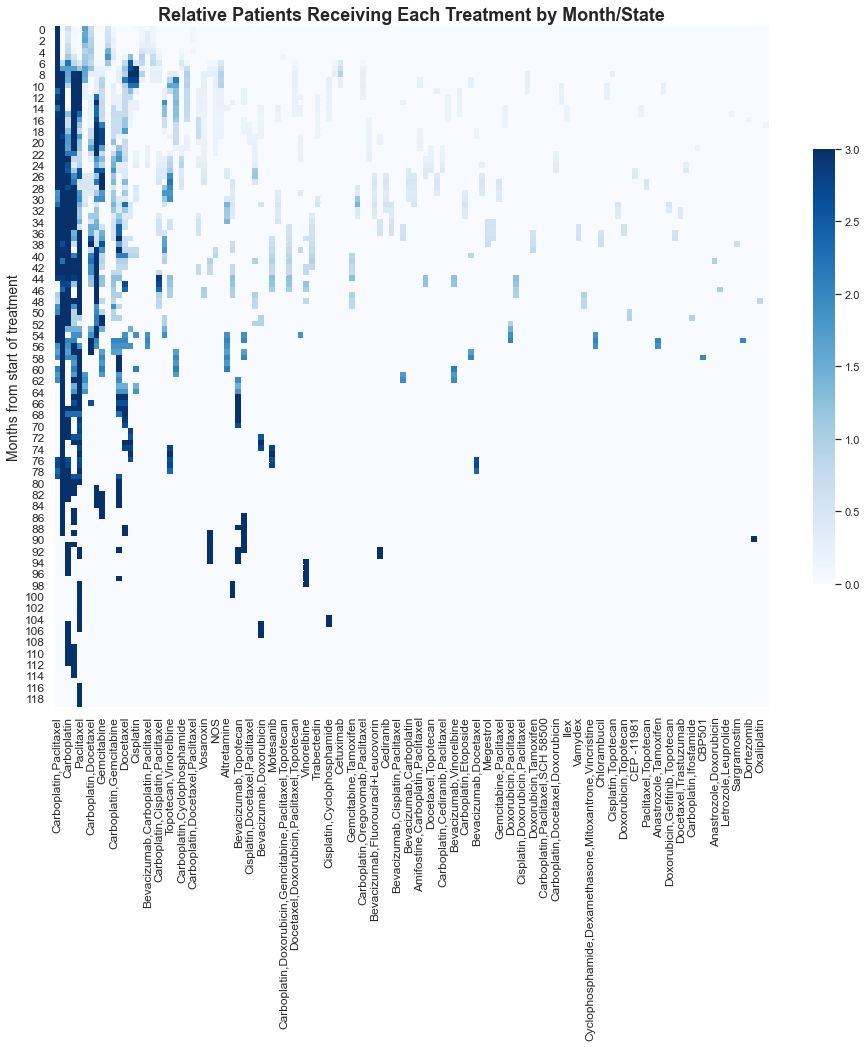

In [290]:
# Heatmap data
df_heat = df_reg.stb.freq(['ther_str', 'months'])[['ther_str', 'months', 'count']].sort_values(by=['months', 'ther_str'])
df_heat = df_heat.pivot_table(index=['months'], columns='ther_str', values='count').reset_index().rename_axis(None, axis=1).set_index('months')
df_heat = df_heat.fillna(value=0).drop([''], axis=1)
s = df_heat.sum()
df_heat = df_heat[s.sort_values(ascending=False).index]
# convert to z-scores
for row in df_heat.index:
    stats.zscore(df_heat.iloc[row])
    df_heat.iloc[row] = stats.zscore(df_heat.iloc[row])
df_heat = df_heat.fillna(value=0)

# Make heatmap
sns.set(font_scale=1)

cmap = sns.color_palette("Blues", as_cmap=True)
plt.figure(figsize=(16,16))
plt.rcParams["font.family"] = "Arial"
ax = sns.heatmap(data=df_heat,
                 cmap=cmap, 
                 square=1,
                 vmin=0, vmax=3,
                 cbar_kws={"shrink": .5},
#                  linewidth=0.05,
#                  linecolor='gray',
                 )
plt.title('Relative Patients Receiving Each Treatment by Month/State', size=18, fontweight='bold')
plt.ylabel('Months from start of treatment', size=14)
plt.xticks(size=12, rotation='vertical')
plt.yticks(size=12)
# cbar = df_heat.collections[0].colorbar
# cbar.ax.tick_params(labelsize=6)

## Create MDP objects

* This should probably be the start of the next notebook

State and Action set

In [291]:
# States
state_set = ['N', 'T', 'D']

# Combos resulting from actions
combos_all = list(lines_df_2['therapy'])
combos_all.sort()
combos_all = list(combos_all for combos_all,_ in itertools.groupby(combos_all))
print(len(combos_all))
print(combos_all[0:10])

combos_all_drugs = combos_all.copy()
combos_all_drugs.remove([])
print(combos_all_drugs[0:10]) 

# Combos for deceased patients
combos_d = list(lines_df_d['therapy'])

combos_d.sort()
combos_d = list(combos_d for combos_d,_ in itertools.groupby(combos_d))
print(len(combos_d))
print(combos_d[0:10])

combos_drugs_d = combos_d.copy()
combos_drugs_d.remove([])
print(combos_drugs_d[0:10]) 

128
[[], ['Abagovomab'], ['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'], ['Amifostine', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Paclitaxel'], ['Aminocamptothecin'], ['Anastrozole']]
[['Abagovomab'], ['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'], ['Amifostine', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Paclitaxel'], ['Aminocamptothecin'], ['Anastrozole'], ['Anastrozole', 'Doxorubicin']]
108
[[], ['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'], ['Amifostine', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Paclitaxel'], ['Aminocamptothecin'], ['Anastrozole'], ['Anastrozole', 'Doxorubicin']]
[['Aldesleukin'], ['Altretamine'], ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel'], ['Amifostine', 'Carboplatin', 'Paclitaxel'

Static transition matrix

In [292]:
# States = {No Treatment, Treatment, Death}
combos = combos_d # Switch to _all when use full dataset
combos_drugs = combos_drugs_d

nactions = len(combos) # action set is list of unique drug combos, not including choosing no drugs
nstates = len(state_set) # three state probabilities

# Initialize transition matrix
transitions = np.zeros((nactions,nstates-1,nstates))
print('T_a shape:\n',
      '   N  T  D\n',
      'N', transitions[0][0],'\n',
      'T', transitions[0][1])

# Calculate probabilities
for i in range(nactions):
    inds = get_index_pos(list(lines_df_2['therapy']), combos[i])
    
    n_prob = lines_df_2[['no_treat']].iloc[inds, :].sum().values[0] / lines_df_2[['total_ev']].iloc[inds, :].sum().values[0]
    t_prob = lines_df_2[['treat']].iloc[inds, :].sum().values[0] / lines_df_2[['total_ev']].iloc[inds, :].sum().values[0]
    d_prob = lines_df_2[['death']].iloc[inds, :].sum().values[0] / lines_df_2[['total_ev']].iloc[inds, :].sum().values[0]
    # placeholder so that every action has a chance of death. Will update with regression to calc probs
    # if d_prob == 0:
    #   d_prob = .1
    #   n_prob = n_prob - (d_prob / 2)
    #   t_prob = t_prob - (d_prob / 2)
    ###################################################################################################

    if combos[i] == []:
        # N --> 
        transitions[i][0][0] = n_prob
        transitions[i][0][1] = t_prob
        transitions[i][0][2] = d_prob
        # T -->
        transitions[i][1][0] = 0
        transitions[i][1][1] = 0
        transitions[i][1][2] = 0
    else:
        # N --> 
        transitions[i][0][0] = 0
        transitions[i][0][1] = 0
        transitions[i][0][2] = 0
        # T -->
        transitions[i][1][0] = n_prob
        transitions[i][1][1] = t_prob
        transitions[i][1][2] = d_prob

# Get tranistion probabilities function
def get_probs(act_choice, curr_state, trans_set=transitions, act_set=combos, states_set=state_set):
    return trans_set[act_set.index(act_choice)][states_set.index(curr_state)]

transitions[0:10]

T_a shape:
    N  T  D
 N [0. 0. 0.] 
 T [0. 0. 0.]


array([[[0.84903439, 0.15096561, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.25      , 0.75      , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.26315789, 0.68421053, 0.05263158]],

       [[0.        , 0.        , 0.        ],
        [0.11111111, 0.88888889, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.33333333, 0.66666667, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.33333333, 0.66666667, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.16666667, 0.83333333, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.2       , 0.8       , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        ]]])

Transition probability regression

In [293]:
# OLS Linear, event on time and treatment, only patients who died
        # Treatment prob
X = np.array(df_d_reg.loc[:, 'months':])
y = np.array(df_d_reg['treat'])
t_reg = LinearRegression().fit(X, y)

        # No treatment prob
y = np.array(df_d_reg['no_treat'])
n_reg = LinearRegression(fit_intercept=False).fit(X, y)

        # Death prob
y = np.array(df_d_reg['death'])
d_reg = LinearRegression(fit_intercept=False).fit(X, y)

# MinMax and sum to 1 scaling for negative probs
scaler = MinMaxScaler(feature_range=(0.05, 0.95)) # maybe change min to the overall proportion of deaths to total transitions

def scaleMM(inprobs):
    scaler.fit(inprobs.reshape(-1, 1))
    outprobs = scaler.transform(inprobs)
    outprobs = outprobs / outprobs.sum()
    return outprobs

# Function to calculate transition probabilities based on regressions
def reg_probs(state, months, action):
    act_ind = combos.index(action) + 2
    x_test = np.zeros(110)
    x_test[0] = months
    x_test[1] = state_set.index(state)
    x_test[act_ind] = 1
    x_test = x_test.reshape(1,-1)
    probs = np.array([[n_reg.predict(x_test)[0], t_reg.predict(x_test)[0], d_reg.predict(x_test)[0]]])
    probs = scaleMM(probs)[0].tolist()
    return probs

# check that it works
reg_probs('N', 0, ['Carboplatin', 'Paclitaxel'])

[0.047619047616918465, 0.9047619047214508, 0.047619047661630644]

In [294]:
# # If want formatted regression output
# import statsmodels.api as sm
# # from scipy import stats

# # X = sm.add_constant(X)
# est = sm.OLS(y, X)
# est2 = est.fit()
# print(est2.summary())
# est2.predict(x_test)

Q-Network: MLP

In [295]:
# Define DQN, one hidden layer MLP for now
class DQN(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super(DQN, self).__init__()
        self.fc = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        out = self.fc(x)
        out = self.relu(out)
        out = self.fc_out(out)
        return out

In [296]:
# Create a better NN
class DQN_3(nn.Module):
    def __init__(self, in_features, out_features):
        super(DQN_3, self).__init__()
        self.fc1 = nn.Linear(in_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(64, out_features)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc_out(out)
        return out

Replay Memory

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [297]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Model training loop

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [298]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## Environment

Designed based on: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/GridWorld/gridWorld.py

State Class

In [299]:
# Globals
START_STATE = 'T'
START_COMBO = []
GAMMA = 0.3
EXP_RATE = 0.3
BATCH_SIZE = 100
TARGET_UPDATE = 5

# policy = DQN(2, 100, len(combos_drugs)).to(device) # input features are the state and the number of previous states
# target_net = DQN(2, 100, len(combos_drugs)).to(device)
policy = DQN_3(2, len(combos_drugs)).to(device)
target_net = DQN_3(2, len(combos_drugs)).to(device)
target_net.load_state_dict(policy.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy.parameters())
memory = ReplayMemory(10000)

class State:
    def __init__(self, state=START_STATE):
        self.state = state
        self.isEnd = False

    # Give reward: for now, simple rewards
    def giveReward(self):
        if self.state == 'N':
            return 1 
        elif self.state == 'T':
            return 1
        elif self.state == 'D':
            return -1 
    
    def isEndFunc(self):
        if self.state == 'D':
            self.isEnd = True

    # Update step
    def nxtPosition(self, action, months):
        # Choose probabilities from transition matrix
#         probs = get_probs(action, self.state) # static probs
        probs = reg_probs(self.state, months, action) # regression probs
        # Return next state
        nxtState = random.choices(state_set, weights=probs, k=1)[0]
        return nxtState

Agent Class

In [300]:
class Agent:
    def __init__(self):
        self.State = State()        
        self.s_a = []
        self.actions = combos_drugs
#         self.lr = LEARN_RATE # this isn't doing anything right now
        self.exp_rate = EXP_RATE
        # initial state and action reward
        self.state_values = {'N':1, 'T':1, 'D':-1}       # not sure if need these, need action values instead. Can it be like: Combo: Value - xt?
        self.statevals_list = [1, 1, -1]      # for [N, T, D]
        self.s_a_values = {} 
        for i in state_set:
            for j in combos:
                self.s_a_values[repr([i, j])] = 0
    
    # Choose Action
    def chooseAction(self):
        # choose action with most expected value
        mx_exp_reward = 0

        if self.State.state == 'N':
            action = []
        else:
            if np.random.uniform(0, 1) <= self.exp_rate:
                action = self.actions[np.random.choice(len(self.actions))]
            else:
                # greedy action
                with torch.no_grad():
                    state_t = torch.FloatTensor([state_set.index(self.State.state), len(self.s_a)])
                    act = policy(state_t).max(0)[1].item()
                    action = self.actions[act]
        return action

    def takeAction(self, action):
        position = self.State.nxtPosition(action, len(self.s_a))
        return State(state=position)

    def reset(self):
        self.s_a = []
        self.State = State()

    def play(self, rounds=20, verbose=True):
        i = 0
        total_reward_list = [] ########################
        while i < rounds:
            # to the end of game back propagate reward
            if self.State.isEnd:
                # back propagate
                reward = self.State.giveReward()
                # explicitly assign end state to reward values
                # self.s_a_values[repr([self.State.state, action])] = reward  # this is optional
                # for s in reversed(self.s_a):
                #     reward = self.s_a_values[repr([s[0], s[1]])] + self.lr * (reward - self.s_a_values[repr([s[0], s[1]])]) # I think i need to update this formula because using (s,a) now
                #     self.s_a_values[repr([s[0], s[1]])] = reward
                # Calculate total reward
                total_reward = 0
                for s in self.s_a:
                    total_reward += self.state_values[s[0]]
                if verbose:
                    print(self.s_a)
                    print('Total reward: ', total_reward)
                    print('----------------------------------------------------')
                total_reward_list.append(total_reward)

                self.reset()
                i += 1
            else:
                action = self.chooseAction()
                try:
                    act_ind = torch.tensor([combos_drugs.index(action)])
                except ValueError:
                    pass
                # append trace
                self.s_a.append([self.State.state, action])
                if verbose:
                    print('current state {} action {}'.format(self.State.state, action))
                
                s_t = torch.FloatTensor([state_set.index(self.State.state), len(self.s_a)]) 
                # by taking the action, it reaches the next state
                self.State = self.takeAction(action)
                # save transition vals for memory
                s_t1 = torch.FloatTensor([state_set.index(self.State.state), len(self.s_a) + 1])
                r_t = torch.FloatTensor([self.State.giveReward()])
                # store transition in memory
                if action != []:
                    memory.push(s_t, act_ind, s_t1, r_t)
                else:
                    pass
                # perform an optimizaiton step
                optimize_model()
                # update target model
                if i % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy.state_dict())
                # mark is end
                self.State.isEndFunc()
                if verbose:
                    print('nxt state', self.State.state)
                    print('---------------------')
        return total_reward_list

Treat patients

In [301]:
if __name__ == '__main__':
    ag = Agent()
    reward_hist = ag.play(rounds=1000, verbose=True)
    # print(ag.s_a_values)

current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cyclophosphamide']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['N', []], ['N', []]]
Total reward:  4
----------------------------------------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cyclophosphamide', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
curren

nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cyclophosphamide']], ['T', ['Cyclophosphamide']], ['T', ['Cyclophosphamide']], ['T', ['Cyclophosphamide']], ['T', ['Cyclophosphamide']], ['T', ['Docetaxel', 'Trastuzumab']],

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Topotecan']
nxt state D
---------------------
[['T', ['Vinorelbine']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Topotecan']]]
Total reward:  6
----------------------------------------------------
current state T action ['Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Capecitabine']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Docetaxel']
nxt st

current state T action ['Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Cyclophosphamide', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Amifostine', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Anastrozole', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Carboplatin

nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Cyclophosphamide']], ['T', ['Bevacizumab', 'Cyclophosphamide']], ['N', []], ['T', ['Bevacizumab', 'Topotecan']], ['N', []], ['N', []], ['N', []], ['T', ['Vosaroxin']], ['T', ['Carboplatin', 'Gemci

current state T action ['Amifostine', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Chlorambucil']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Etoposide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Motesanib']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
--------------------

nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Docetaxel', 'Lily']
nxt state T
---------------------
current state T action ['Oxaliplatin']
nxt state D
---------------------
[['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Anastrozole', 'Doxorubicin']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Pemetrexed']], ['N', []], ['T', ['Docetaxel', 'Lily']], ['T', ['Oxaliplatin']]]
Total reward:  11
----------------------------------------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Irinotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Tamoxifen']
n

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Etoposide', 'Gemcitabine']
nxt state D
---------------------
[['T', ['Bevacizumab', 'Fluorouracil+Leucovorin']], ['N', []], ['N', []], ['N', []], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'Topotecan']], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab']], ['T', ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['T', ['Amifostine', 'Carbopla

current state T action ['Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Tamoxifen']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Docetaxel', 'Lily']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SC

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Anastrozole', 'Doxorubicin']], ['T', ['Carboplatin', 'Tamoxifen']], ['T', ['CBP501']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Aminocamptothecin']], ['N', []], ['N', []], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Topotecan']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Docetaxel', 'Gemcitabine']], ['T', ['Docetaxel', 'Gemcitabine']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['CEP -11981']], ['N', []], ['N', []], ['N'

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
--------------

current state T action ['Carboplatin', 'Etoposide']
nxt state D
---------------------
[['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Paclitaxel']], ['T', ['Carboplatin', 'Etoposide']]]
Total reward:  4
----------------------------------------------------
current state T action ['Oxaliplatin']
nxt state D
---------------------
[['T', ['Oxaliplatin']]]
Total reward:  1
----------------------------------------------------
current state T action ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Irinotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Capecitabine']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state D
---------------------
[['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Topotecan', 'Vinorelbine']], ['N', []], ['N', []], ['T', ['Cisplatin', 'Cyclophosphamide']], ['T', ['Doxorubicin']], ['N', []], ['N', []], ['N', []], ['T', ['Capecitabine']], ['T', ['Bevacizumab']], ['T', ['Cisplatin']]]
Total reward:  12
----------------------------------------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Tamoxifen', 'Topotecan']
nxt state T
------------

nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cycl

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['NOS']], ['N', []], ['T', ['NOS']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Fluorouracil+Leucovorin']], ['N', []], ['N', []], ['T', ['Aldesleukin']], ['T', ['Carboplatin', 'Docetaxel']], ['T', ['Carboplatin', 'Docetaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['T', ['Carboplatin', 'Docetaxel']], ['T', ['Bevacizumab']], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['N', []], ['T', ['Irofulven']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  33
----------------------------------------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt s

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Aminocamptothecin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Oxaliplatin']], ['T', ['Docetaxel', 'Topotecan']], ['T', ['Car

current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Cisplatin', 'Gemcitabine']], ['T', ['Vinorelbine']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Oregovomab']], ['T', ['Gemcitabine']], ['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['N', []]]
Total reward:  13
----------------------------------------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current sta

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['N', []], ['N', []], ['N', []]]
Total reward:  5
----------------------------------------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['NOS']
nxt state D
---------------------
[['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Sargramostim']], ['T', ['Cisplatin', 'Topotecan']], ['T', ['Bevacizumab']], ['T', ['Carboplatin', 'Gemcitabine', 'Paclitaxel']], ['T', ['N

current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Anastrozole', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Oxaliplatin']
nxt state D
---------------------
[['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['NOS']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Anastrozole', 'Tamoxifen']], ['T', ['Oxaliplatin']]]
Total reward:  8
----------------------------------------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state N
------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
-----------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Topotecan', 'Vi

current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
n

nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Anastrozole']], ['N', []], ['T', ['Carboplatin', 'Paclitaxel', 'Topotecan']], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Carboplatin']], ['T', ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']], ['T', ['Carboplatin', 'Doxorubicin', 'Paclitaxel']]]
Total reward:  9
----------------------------------------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt state N
---------------------
current state N ac

nxt state T
---------------------
current state T action ['Ifosfamide']
nxt state T
---------------------
current state T action ['Altretamine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state D
---------------------
[['T', ['Docetaxel', 'Gemcitabine']], ['N', []], ['T', ['Cisplatin', 'Topotecan']], ['T', ['Anastrozole']], ['T', ['Cisplatin', 'Paclitaxel']], ['N', []], ['N', []], ['N', []], ['

current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt stat

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Anastrozole']], ['T', ['Vosaroxin']], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  6
----------------------------------------------------
current state T action ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['CBP501']
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['T', ['Bevacizumab', 'Gemcitabine']], ['T', ['Cisplatin', 'Topotecan']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['CBP501']], ['N', []]]
Total reward:  6
-------------------------

nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Vosaroxin']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Vosaroxin']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Vosaroxin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Vinorelbine']
nxt state D
---------------------
[['T', ['Paclitaxel', 'Topotecan']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Gemcitabine']], ['T', ['Anastrozole', 'Doxorubicin']], ['T', ['Carboplatin', 'Cyclophosphamide']], ['N', []], ['T', ['Carboplatin', 'Paclitaxel', 'Tamoxifen']], ['T', ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']], ['N', []], ['N', []], ['N', []], ['T', ['Sargramostim']], ['N', []], ['N', []], ['T', ['Carboplatin', 'Doxorubicin', 'Paclitax

current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Gemcitabine']], ['T', ['Docetaxel', 'Topotecan']], ['T', ['Bevacizumab', 'Cyclophosphamide']], ['T', ['Bevacizumab', 'Cyclophosphamide']

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state D
---------------------
[['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Carboplatin', 'Pemetrexed']]]
Total reward:  10
----------------------------------------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
----------------

current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------


nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitab

current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Doxorubicin', 'Paclitaxel']], ['T', ['Chlorambucil']], ['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Amifostine', 'Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Etoposide']], ['T', ['Carboplatin', 'Pemetrexed']], ['N', []], ['N', []]]
Total reward:  24
----------------------------------------------------
current state T action ['Gemcitabine', 'Tamoxifen']
nxt state T
---------------------
cu

current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
--------------

nxt state T
---------------------
current state T action ['Amifostine', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['T', ['Amifostine', 'Paclitaxel']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  7
----------------------------------------------------
current state T action ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Doc

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state D
---------------------
[['T', ['Cisplatin']], ['T', ['Cisplatin']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Patupilone']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'Trastuzumab']], ['T', ['Carboplatin', 'Doxorubicin', 'Paclitaxel']], ['T', ['Anastrozole']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Cisplatin', 'Tamoxifen']]]
Total reward:  13
----------------------------------------------------
current state T action ['Bevacizumab', 'Vinorelbine']
nxt state D
---------------------
[['T', ['Bevacizumab', 'Vinorelbine']]]
Total reward:  1
----------------------------------------------------
current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['Gemcitabine']
nxt 

current state T action ['Patupilone']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state N
--

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['NOS']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N actio

nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Amifostine', 'Paclitaxel']], ['T', ['Capecitabine']], ['T', ['Cisplatin', 'Cyclophosphamide']], ['N', []], ['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Doxorubicin', 'Gefitinib', 'Topotecan']], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Gemcitabine']]]
Total reward:  14
----------------------------------------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Sargramostim']], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Paclitaxel']]]
Total reward:  5
------

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state D
---------------------
[['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['T', ['Letrozole']], ['T', ['Bevacizumab']], ['T', ['Cisplatin']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Letrozole', 'Leuprolide']], ['T', ['Altretamine']], ['T', ['Ilex']], ['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Tamoxifen']], ['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Pemetrexed']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Cisplatin', 'Cyclophosphamide']]]
Total reward:  27
----------------------------------------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
curren

nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Carboplatin', 'Gemcitabine', 'Paclitaxel']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Vamydex']], ['T', ['Amifostine', 'Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Carboplatin', 'Pemetrexed']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Cyclophosphamide']], ['T', ['Topotecan']], 

current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Amifostine', 'Paclitaxel']], ['T', ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']], ['N', []], ['N', []], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Carboplatin', 'Etoposide']], ['N', []], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['N', []], ['T', ['Vamydex']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], 

nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Oregovomab']], ['T', ['Patupilone']], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Carboplatin', 'Paclitaxel', 'Vinorelbine']], ['T', ['Carboplatin', 'Docetaxel', 'Doxorubicin']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']]]
Total reward:  10
----------------------------------------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Anastrozole', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Etoposide', 'Gemcitabine']
nxt state T
---------------------
current 

current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
cu

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Vamydex']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel']]]
Total reward:  8
----------------------------------------------------
current state T action ['Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Leuprolide']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
-----

nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state D
---------------------
[['T', ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Paclitaxel', 'Topotecan']], ['T', ['Carboplatin', 'Docetaxel', 'Leuprolide']], ['T', ['Capecitabine']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Carboplatin', 'Paclitaxel', 'Trastuzumab']], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Tamoxifen', 'Topotecan']], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Etoposide', 'Gemcitabine']], ['T', ['Vosaroxin']], ['T', ['Carboplatin', 'Doxorubicin', 'Paclitaxel']], ['T', ['Carboplatin', 'Etoposide']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Anastrozole']], ['T', ['Aldesleukin']], ['N', []], ['N', []], ['T', ['Topotecan']], ['T', ['Topotecan']], ['T', ['Bevacizumab', 'Vinorelbine']], ['T', ['Carboplatin', 'Gemci

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Carboplatin', 'Paclitaxel', 'SCH 58500']], ['T', ['Carboplatin', 'Docetaxel', 'Leuprolide']], ['T', ['Cisplatin']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'Trastuzumab']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Gemcitabine']], ['N', []], ['T', ['Bevacizumab', 'Paclitaxel']], ['T', ['CBP501']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Docetaxel', 'Trastuzumab']], ['T', ['Cisplatin']], ['T', ['Docetaxel', 'Trastuzumab']]]
Total reward:

current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Irofulven']
nxt state D
---------------------
[['T', ['Vamydex']], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Carboplatin']], ['T', ['Cisplatin']], ['T', ['Carboplatin', 'Etoposide']], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Cyclophosphamide']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Irofulven']]]
Total reward:  11
----------------------------------------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N acti

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Vamydex']], ['T', ['Sargramostim']], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Vinorelbine']], ['N', []], ['N', []]]
Total reward:  7
----------------------------------------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
----------------

current state T action ['NOS']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Anastrozole', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevaciz

current state T action ['Sargramostim']
nxt state D
---------------------
[['T', ['Sargramostim']]]
Total reward:  1
----------------------------------------------------
current state T action ['Cisplatin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state D
---------------------
[['T', ['Cisplatin', 'Gemcitabine']], ['T', ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']]]
Total reward:  2
----------------------------------------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
curr

current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Leuprolide']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt stat

current state T action ['Bevacizumab', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state D
---------------------
[['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Carboplatin', 'Docetaxel', 'Leuprolide']], ['T', ['Bevacizumab', 'Topoteca

nxt state T
---------------------
current state T action ['Tamoxifen', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Leuprolide']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['NOS']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['NOS']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Motesanib']
nxt state T
---------------------
current state T action ['Motesa

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Vosaroxin']], ['T', ['Dortezomib']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  8
----------------------------------------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Ilex']
nxt state T
-

[['T', ['Carboplatin', 'Doxorubicin', 'Paclitaxel']], ['T', ['Carboplatin', 'Gemcitabine', 'Paclitaxel']], ['T', ['Doxorubicin', 'Paclitaxel']], ['T', ['Doxorubicin', 'Gefitinib', 'Topotecan']], ['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['T', ['Letrozole', 'Leuprolide']], ['T', ['Anastrozole']], ['N', []], ['N', []], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Bevacizumab', 'Topotecan']], ['T', ['Bevacizumab', 'Topotecan']], ['N', []], ['N', []]]
Total reward:  14
----------------------------------------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
n

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Ifosfamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N acti

nxt state T
---------------------
current state T action ['Cyclophosphamide', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Irinotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt 

current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['NOS']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state N
---------------------
curre

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Tamoxifen', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------

current state T action ['Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Docetaxel', 'Lily']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Cyclophosphamide', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carb

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']


nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Bevacizumab', 'Carboplatin']], ['T', ['Cisplatin']], ['T', ['Carboplatin', 'Gemcitabine']], ['T', ['CBP501']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Docetaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']]]
Total reward:  13
----------------------------------------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Carbopl

nxt state D
---------------------
[['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['T', ['Etoposide']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Paclitaxel']]]
Total reward:  10
----------------------------------------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide', 'Topotecan']
nxt state D
---------------------
[['T', ['Bevacizumab', 'Carboplatin']], ['T', ['Carboplatin', 'Cyclophosphamide', 'Topotecan']]]
Total reward:  2
----------------------------------------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Doxorubicin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
----------

current state T action ['Bevacizumab', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T actio

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Bevacizumab', 'Carboplatin']], ['N', []], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Topotecan']], ['T', ['Anastrozole', 'Doxorubicin']], ['T', ['Carboplatin', 'Paclitaxel']]]
Total reward:  7
----------------------------------------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state T
---------------------
current state T action ['Etoposide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N act

current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Anastrozole', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Topote

nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N ac

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cisplatin']], ['T', ['Capecitabine']], ['T', ['Cisplatin', 'Docetaxel']], ['N', []], ['T', ['Gemcitabine', 'Topotecan']], ['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Cisplatin', 'Docetaxel']], ['T', ['Letrozole', 'Leuprolide']], ['T', ['Vosaroxin']], ['N', []], ['N', []], ['N', []]]
Total reward:  12
----------------------------------------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['NOS']
nxt state T
---------------------
current state T action ['Altretamine']
nxt state D
--------------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Chlorambucil']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt

Total reward:  31
----------------------------------------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Aminocamptothecin']
nxt state T
---------------------
current state T action ['Anastrozole', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Vinorelbine']
nxt 

nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Ilex']
nxt state T
---------------------
current state T action ['Amifostine', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state D
---------------------
[['T', ['Carboplatin', 'Cyclophosphamide']], ['T', ['Sargramostim']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Carboplatin']], ['T', ['Carboplatin', 'Paclitaxel', 'Trastuzumab']], ['T', ['Doxorubicin']], ['T', ['Bevacizumab', 'Carboplatin']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Topotecan']], ['T', ['Carboplatin', 'Pacl

current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
cu

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Chlorambucil']
nxt state T
---------------------
current state T action ['Carboplatin', 'Ifosfamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Bevacizumab', 'Gemcitabine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Chlorambucil']], ['T', ['Carboplatin', 'Ifosfamide']], ['N', []], ['N', []]]
T

current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Docetaxel', 'Trastuzumab']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Docetaxel']], ['T', ['Anastrozole']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  11
----------------------------------------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state

Total reward:  14
----------------------------------------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Irofulven']
nxt state D
---------------------
[['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Irofulven']]]
Total reward:  4
----------------------------------------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Chlorambucil']
nxt state D
---------------------
[['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Carb

current state T action ['Aldesleukin']
nxt state T
---------------------
current state T action ['Anastrozole', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Vosaroxin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
------

current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Ifosfamide']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
--------------------

current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['CBP501']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Topotecan']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Vamydex']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Vinorelbine']
nxt state T
---------------------
current state T action ['CBP50

current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Carboplatin', 'Doxorubicin', 'Paclitaxel']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Doxorubicin', 'Tamoxifen']], ['T', ['Carboplatin', 'Gemcitabine']], ['T', ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab']], ['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Carboplatin', 'Paclitaxel', 'Vinorelbine']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Bevacizumab', 'Fluorouracil+Leucovorin']], ['T', ['Gemcitabine']], ['T', ['CBP501']], ['T', ['Gemcitabine']], ['T', ['Cyclophosphamide', 'Paclitaxel']], ['T', ['Anastrozole']], ['T', ['Cyclophosphamide', 'Paclitaxel']], ['T', ['Doxorubicin', 'Tamoxifen']], ['T', ['Doxorubi

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Aminocamptothecin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------

nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state T
---------------------
current state T action ['Oxaliplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N actio

current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Paclitaxel', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Let

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Gemcitabine',

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state N
---------------------
current 

nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Carboplatin', 'Paclitaxel', 'Trastuzumab']], ['T', ['Doxorubicin', 'Gefitinib', 'Topotecan']], ['T', ['Letrozole']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Capecitabine', 'Docetaxel']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']], ['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Cisplatin', '

nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state T
---------------------
current state T action ['Vamydex']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Tamoxifen']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current 

---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state N
---------------------
current state N action 

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Ilex']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['NOS']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Pa

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Docetaxel', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Aldesleukin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state 

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
----------------

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['CBP501']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  9
----------------------------------------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Capecitabine']
nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nx

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Topotecan']], ['T', ['Amifostine', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'Trastuzumab']], ['N', []], ['N', []]]
Total reward:  14
----------------------------------------------------
curr

nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Anastrozole']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Irinotecan', 'Vinorelbine']
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Etoposide']], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Ifosfamide']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Doxorubicin', 'Tamoxifen']], ['T', ['Carboplatin', 'Cyclophosphamide']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Anastrozole']], ['T', ['Anastrozole']], ['T', [

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Docetaxel', 'Trastuzumab']], ['T', ['Bevacizumab', 'Paclitaxel']], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Vamydex']], ['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Doxorubicin', 'Tamoxifen']], ['T', ['Cisp

nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nxt state D
---------------------
[['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Vinorelbine']], ['T', ['Bevacizumab', 'Paclitax

current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state D
---------------------
[['T', ['Doxorubicin', 'Gemcitabine']], ['T', ['Carboplatin', 'Docetaxel', 'Paclitaxel']], ['T', ['Etoposide', 'Gemcitabine']], ['T', ['Bevacizumab', 'Doxorubicin']], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Paclitaxel']], ['T', ['Ilex']], ['T', ['Doxorubicin', 'Paclitaxel']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Anastrozole']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []],

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Carboplatin', 'Gemcitabine', 'Paclitaxel']], ['N', []], ['T', ['Docetaxel', 'Trastuzumab']], ['T', ['NOS']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Doxorubicin', 'Tamoxifen']], ['T', ['Docetaxel']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['CBP501']], ['N', []], ['T', ['Doxorubicin', 'Paclitaxel']], ['T', ['Am

current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Ifosfamide']], ['N', []], ['T', ['Capecitabine']], ['T', ['Ifosfamide']], ['T', ['Ifosfamide']], ['T', ['Carboplatin', 'Paclitaxel', 'Topotecan']], ['N', []], ['N', []], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Cisplatin', 'Cyclophosphamide', 'Doxorubicin', 'Paclitaxel']]]
Total reward:  11
----------------------------------------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt sta

nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Etoposide', 'Gemcitabine']], ['T', ['Doxorubicin', 'Gemcitabine']], ['T', ['Doxorubicin', 'Gemcitabine']], ['T', ['Doxorubicin', 'Gemcitabine']], ['T', ['Letrozole', 'Leuprolide']], ['T', ['Gemcitabine', 'Paclitaxel']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Topotecan']], ['T', ['Topotecan']], ['T', ['Topotecan']], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin']], ['T', ['Carboplatin', 'Cyclophosphamide']], ['T', ['Aminocamptothecin']], ['N', []]]
Total reward:  26
----------------------------------------------------
current state T action ['Motesanib']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state N
---

nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Letrozole', 'Leuprolide']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Docetaxel', 'Trastuzumab']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  17
----------------------------------------------------
current state T action ['Patupilone']
nxt state D
---------------------
[['T', ['Patupilone']]]
Total reward:  1
----------------------------------------------------
current state T action ['Ifosfamide']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Carboplatin

nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Sorafenib']], ['T', ['Amifostine', 'Carboplatin', 'Paclitaxel']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Paclitaxel']]]
Total reward:  14
----------------------------------------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosph

nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state D
---------------------
[['T', ['Doxorubicin', 'Gemcitabine', 'Topotecan']], ['T', ['Carboplatin', 'Cyclophosphamide']], ['T', ['Patupilone']], ['T', ['Oregovomab']]]
Total reward:  4
----------------------------------------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Doxorubicin']
nxt state T
---------------------
cur

---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Carboplatin', 'Etoposide']], ['T', ['Patupilone']], ['N', []], ['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Vamydex']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Topotecan']], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['N', []], ['T', ['Carboplatin', 'Docetax

nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Cyclophosphamide', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Tamoxifen', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Doxo

nxt state T
---------------------
current state T action ['Carboplatin', 'Ifosfamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cyclophosphamide', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Docetaxel', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state N
---------------------
current st

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Patupilone']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  12
----------------------------------------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
-------------

current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state D
---------------------
[['T', ['Patupilone']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Aldesleukin']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Carboplatin']], ['T', ['Tamoxifen']], ['T', ['Bevacizumab', 'Fluorouracil+Leucovorin']], ['N', []], ['N', []], ['N', []], ['T', ['Cisplatin']], ['T', ['Doxorubicin', 'Gefitinib', 'Topotecan']]]
Total reward:  18
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Anastrozole', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['CBP501']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state D
-----------

nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Docetaxel']
nxt state T
-

nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Etoposide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Carboplatin', 'Docetaxel', 'Paclitaxel']], ['T', ['Patupilone']], ['T', ['Doxorubicin']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Paclitaxel']], ['N', []], ['T', ['Chlorambucil']], ['T', ['Tamoxifen']], ['N', []], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Carboplatin', 'Etoposide']], ['T', ['Etoposide']], ['

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Trabectedin']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Gemcitabine', 'Tamoxifen']], ['T', ['Vamydex']], ['N', []], ['N', []], ['T', ['Carboplatin', 'Gemcitabine', 'Paclitaxel']], ['T', ['Docetaxel']], ['T', ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']], ['T', ['Altretamine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Trabectedin']], ['T', ['Trabectedin']], ['T', ['Aldesleukin']], ['T', ['Aminocamptothecin']], ['T', ['Carboplatin', 'Ifosfamide']], ['N', []], ['T', ['Gemcitabine', 'Tamoxifen']], ['T', ['Bevacizumab', 'Gemcitabine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', 

current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Vamydex']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
n

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Altretamine']
nxt state T
---------------------
current state T action ['Altretamine']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Altretamine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state N
---------------------
current state N action []
nxt state T
-----

nxt state T
---------------------
current state T action ['Vamydex']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt s

current state T action ['Trabectedin']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplat

current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Ifosfamide']
nxt state N
---------------------
current state N action []
nxt state N
---------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Cisplatin', 'Docetaxel']], ['T', ['Bevacizumab', 'Cyclophosphamide']], ['T', ['Doxorubicin']], ['T', ['Bevacizumab']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []]]
Total reward:  9
----------------------------------------------------
current state T action ['Capecitabine']
nxt state T
---------------------
current state T action ['Aldesleukin']
nxt state T
---------------------
current state T action ['Chlorambucil']
nxt state D
---------------------
[['T', ['Capecitabine']], ['T', ['Aldesleukin']], ['T', ['Chlorambucil']]]
Total reward:  3
----------------------------------------------------
current state T action ['Dortezomib']
nxt state D
---------------------
[['T', ['Dortezomib']]]
Total reward:  1
----------------------------------------------------
c

nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state D
---------------------
[['T', ['Patupilone']], ['N', []], ['T', ['Bevacizumab']], ['T', ['Carboplatin', 'Ifosfamide']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Gemcitabine']], ['T', ['Etoposide']], ['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['T', ['Bevacizumab', 'Fluorouracil+Leucovorin']], ['T', ['Carboplatin', 'Paclitaxel', 'Tamoxifen']], ['T', ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']], ['T', ['Carboplatin', 'Cyclophosphamide', 'Topotecan']], ['T', ['Topotecan', 'Vinorelbine']], ['T', ['Topotecan', 'Vinorelbine']], ['T', ['Bevacizumab', 'Gemcitabine']], ['T', ['Doxorubicin']], ['T', ['Topotecan', 'Vinorelbine']], ['T', ['CEP -11

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
-------------------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Vamydex']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Anastrozole', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Paclitaxel']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Vosaroxin']], ['N', []], ['T', ['Cisplatin', 'Docetaxel']], ['T', ['Vosaroxin']], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['T', ['Docetaxel', 'Topotecan']], ['T', ['Cisplatin', 'Docetaxel']], ['N', []], ['N', []], ['N', []], ['T', ['Vamydex']], ['N', []], ['N', []], ['N', []], ['T', ['Anastrozole', 'Doxorubicin']], ['T', ['Paclitax

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N 

current state T action ['Carboplatin', 'Docetaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Sorafenib']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Cisplatin', 'Gemcitabine']
nxt state D
---------------------
[['T', ['Bevacizumab', 'Carboplatin']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Bevacizumab']], ['T', ['Sorafenib']], ['T', ['Carboplatin', 'Docetaxel', 'Doxorubicin']], ['T', ['Cisplatin', 'Gemcitabine']]]
Total reward:  6
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Cisp

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Docetaxel', 'Doxorubicin']], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Doxorubicin', 'Irinotecan', 'Vinorelbine']], ['T', ['Docetaxel', 'Gemcitabine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Doxorubicin']], ['T', ['CEP -11981']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Anastrozole', 'Tamoxifen']], ['T', ['Docetaxel', 'Topotecan']], ['T', ['Capecitabine']], ['T', ['Anastrozole', 'Tamoxifen']], ['N', []], ['N', []], ['N', []], ['T', ['Topotecan', 'Vinorelbine']], ['T', ['Tamoxifen']], ['T', ['Tamoxifen']], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['T', ['Tamoxifen']], ['T', ['Carboplatin', 'Etoposide']], ['T', ['Doxorubicin', 'Gefitinib', 'Topotecan']], ['T', ['Tamoxifen']], ['T', ['Bevacizumab', 'Topotecan', 

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['Docetaxel']
nxt state T
---------------------
current state T action ['Docetaxel']
nxt state T
---------------------
current state T action ['Aminocamptothecin']
nxt state N
---------------------
current state N action []
nxt state N
----------

current state T action ['Amifostine', 'Cisplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Aminocamptothecin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
----

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['D

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Docetaxel', 'Gemcitabine']], ['N', []], ['T', ['Bevacizumab']], ['T', ['Doxorubicin']], ['T', ['Carboplatin', 'Docetaxel']], ['T', ['Carboplatin', 'Ifosfamide']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Tamoxifen', 'Topotecan']], ['T', ['Topotecan', 'Vinorelbine']], ['T', ['Cisplatin', 'Paclitaxel']], ['T', ['Docetaxel']], ['T', ['Cisplatin', 'Docetaxel']], ['T', ['Trabectedin']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Doxorubicin',

current state T action ['Motesanib']
nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Doxorubicin', 'Tamoxifen']], ['T', ['Letrozole', 'Leuprolide']], ['N', []], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Carboplatin']], ['T', ['Carboplatin']], ['T', ['Altretamine']], ['

---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Carboplatin', 'Tamoxifen']], ['T', ['Capecitabine']], 

nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Anastrozole', 'Tamoxifen']], ['T', ['CBP501']], ['N', []], ['N', []], ['T', ['Motesanib']], ['T', ['Carboplatin']], ['T', ['Cisplatin']], ['T', ['Bevacizumab', 'Paclitaxel']]]
Total reward:  9
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Docetaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T acti

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Vosaroxin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N act

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Cisplatin', 'Gemcitabine']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Docetaxel', 'Lily']
nxt state T
---------------------
current state T action ['Docetaxel', 'Lily']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current st

nxt state T
---------------------
current state T action ['Oregovomab']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state T
---------------------
current state T action ['Docetaxel', 'Gemcitabine']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state T
---------------------
current state T action ['Altretamine']
nxt state T
---------------------
current state T action ['Altretamine']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Do

nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state N
---------------------
current state N

current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Gemcitabine', 'Paclitaxel']], ['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Bevacizumab', 'Carboplatin', 'Paclitaxel']]]
Total reward:  4
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Motesanib']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt s

nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['NOS']
nxt state T
---------------------
current state T action ['NOS']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Motesanib']], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Tamoxifen']], ['T', ['Docetaxel']], ['T', ['NOS']], ['T', ['NOS']], ['N', []], ['T', ['Aminocamptothecin']], ['N', []], ['N', []], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['T', ['Bevacizumab', 'Topotecan', 'Vinorelbine']], ['T', ['NOS']], ['T', ['NOS']]]
Total reward:  17
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['NOS']
nxt state N
---------------------
current state N action []
nxt state N
------

nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Docetaxel', 'Trastuzumab']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T acti

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Anastrozole', 'Doxorubicin']], ['T', ['Bevacizumab']], ['T', ['Altretamine']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Cisplatin', 'Gemcitabine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', 

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin']
nxt state T
---------------------
current state T action ['CBP501']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Etoposide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
---------------------
c

nxt state T
---------------------
current state T action ['Carboplatin', 'Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Paclitaxel']
nxt state T
---------------------
current state T action ['Cyclophosphamide']
nxt state T
---------------------
current state T action ['Catumaxomab']
nxt state D
---------------------
[['T', ['Carboplatin', 'Cyclophosphamide']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Cisplatin', 'Docetaxel']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Paclitaxel']], ['T', ['Cyclophosphamide']], ['T', ['Catumaxomab']]]
Total reward:  8
----------------------------------------------------
current state T action ['Catumaxomab']
nxt state D
---------------------
[['T', ['Catumaxomab']]]
Total reward:  1
----------------------------------------------------
current state T action ['Carboplatin', 'Pemetrexed']
nxt state T
---------------------
current 

nxt state T
---------------------
current state T action ['Paclitaxel']
nxt state D
---------------------
[['T', ['Patupilone']], ['N', []], ['N', []], ['T', ['Gemcitabine', 'Topotecan']], ['T', ['Cisplatin', 'Gemcitabine']], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Gemcitabine']], ['T', ['Paclitaxel']]]
Total reward:  10
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Carboplatin', 'Etoposide']]]
Total reward:  2
----------------------------------------------------
current state T action ['Patupilone']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Altretamine']
nxt state T
---------------------
current state T action ['Topotecan', 'Vinorelbine']
nx

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Amifostine', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Carboplatin', 'Ifosfamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Catumaxomab']
nxt state D
---------------------
[['T', ['Gemcitabine', 'Vinorelbine']], ['T', ['Trabectedin']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin']], ['T', ['Carboplatin', 'Paclitaxel', 'Topotecan']], ['T', ['Cisplatin', 'Cyclophosphamide']], ['T', ['Carboplatin', 'Paclitaxel', 'Topotecan']], ['T', ['Catumaxomab']]]
Total reward:  13
----------------------------------------------------
current state T 

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Oregovomab']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Cisplatin', 'Topotecan']
nxt state D
---------------------
[['T', ['Ilex']], ['T', ['Vinorelbine']], ['T', ['Bevacizumab', 'Paclitaxel']], ['T', ['Amifostine', 'Cisplatin', 'Paclitaxel']], ['N', []], ['N', []], ['T', ['Oregovomab']], ['N', []], ['T', ['Bevacizumab', 'Docetaxel']], ['T', ['Cisplatin', 'Topotecan']]]
Total reward:  10
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Cisplatin', 'Pacli

current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Doxorubicin', 'Gemcitabine', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T actio

nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin']
nxt state T
---------------------
current state T action ['Ifosfamide']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Topotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Etoposide']
nxt state T
---------------------
current state T action ['Cisplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action 

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state T
--------------

nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Cyclophosphamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Vosaroxin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Topotecan']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']], ['N', 

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gefitinib', 'Topotecan']
nxt state T
---------------------
current state T action ['Letrozole']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Irinotecan', 'Vinorelbine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Cisplatin', 'Tamoxifen']
nx

nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'SCH 58500']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Trabectedin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']
nxt state T
---------------------
current state T action ['Etoposide', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel']
nxt state T
---------------------
current state T action ['Doxorubicin', 'Gemcitabine']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
----------

nxt state T
---------------------
current state T action ['Aldesleukin']
nxt state T
---------------------
current state T action ['Aldesleukin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Motesanib']], ['T', ['Doxorubicin', 'Gemcitabine']], ['T', ['Carboplatin', 'Docetaxel', 'Paclitaxel']], ['T', ['Vosaroxin']], ['T', ['Vinorelbine']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Leuprolide']], ['T', ['Carboplatin', 'Docetaxel', 'Leuprolide']], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Carboplatin', 'Oregovomab', 'Paclitaxel']], ['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Et

nxt state T
---------------------
current state T action ['Gemcitabine', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Amifostine', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel', 'Tamoxifen']], ['T', ['Gemcitabine', 'Topotecan']], ['N', []]]
Total reward:  5
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Tamoxifen']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['A

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Doxorubicin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Carboplatin', 'Cyclophosphamide']
nxt state T
---------------------
current state T action ['Tamoxifen', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Capecitabine', 'Docetaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Ifosfamide']
nxt state N
---------------------
current state N action []
nxt

current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Sargramostim']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Doxorubicin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Gemcitabine']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Oregovomab', 'Paclitaxel']
nxt state

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Docetaxel', 'Lily']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Cisplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Doxorubicin']
nxt state T
---------------------
current state T action ['Gemcitabine', 'Vinorelbine']
nxt state N
---------------------
current state N action []
nx

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Docetaxel', 'Oxaliplatin']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
curr

nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state D
---------------------
[['T', ['CBP501']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin']], ['T', ['Carboplatin']]]
Total reward:  9
----------------------------------------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Ifosfamide']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action

nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['NOS']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Docetaxel', 'Paclitaxel']
nxt state T
---------------------
current state T action ['CEP -11981']
nxt state T
---------------------
current state T action ['Paclitaxel', 'Topotecan']
nxt state T
---------------------
current state T action ['Carboplatin', '

nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Carboplatin', 'Paclitaxel']
nxt state D
---------------------
[['T', ['Patupilone']], ['T', ['Letrozole']], ['T', ['Cisplatin', 'Docetaxel']], ['T', ['Cisplatin', 'Docetaxel']], ['T', ['Paclitaxel']], ['T', ['Carboplatin', 'Docetaxel', 'Letrozole', 'Leuprolide']], ['T', ['Paclitaxel']], ['T', ['Carboplatin']], ['T', ['Carboplatin']], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Docetaxel', 'Leuprolide']], ['T', ['Ifosfamide']], ['T', ['Motesanib']], ['T', ['Oregovomab']], ['T', ['Bevacizumab']], ['T', ['Doxorubicin']], ['N', []], ['T', ['Doxorubicin']], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Carboplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Paclitaxel']]]
Total reward:  26
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T acti

nxt state N
---------------------
current state N action []
nxt state D
---------------------
[['T', ['Carboplatin', 'Pemetrexed']], ['T', ['Tamoxifen']], ['T', ['Gemcitabine', 'Vinorelbine']], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['N', []], ['T', ['Tamoxifen']], ['T', ['Tamoxifen']], ['T', ['Tamoxifen', 'Topotecan']], ['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Cisplatin', 'Tamoxifen']], ['T', ['Carboplatin', 'Gemcitabine', 'Paclitaxel']], ['T', ['Doxorubicin', 'Gemcitabine', 'Topotecan']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Letrozole']], ['T', ['Carboplatin', 'Cisplatin', 'Paclitaxel']], ['N', []], ['T', ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Amifostine', 'Carboplatin', 'Cisplatin', 'Paclitaxel']], ['T', ['Amifo

current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Fluorouracil+Leucovorin']
nxt state T
---------------------
current state T action ['Carboplatin']
nxt state T
---------------------
current state T action ['Motesanib']
nxt state T
---------------------
current state T action ['Docetaxel', 'Doxorubicin', 'Paclitaxel', 'Topotecan']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Gemcitabine']
nxt state T
---------------------
current state T action ['Aminocamptothecin']
nxt state N
---------------------
current state N action []
nxt state N
-------

nxt state T
---------------------
current state T action ['Letrozole']
nxt state N
---------------------
current state N action []
nxt state T
---------------------
current state T action ['Doxorubicin']
nxt state T
---------------------
current state T action ['Carboplatin', 'Etoposide']
nxt state T
---------------------
current state T action ['Bevacizumab', 'Paclitaxel']
nxt state T
---------------------
current state T action ['Docetaxel']
nxt state D
---------------------
[['T', ['Trabectedin']], ['T', ['Letrozole']], ['N', []], ['T', ['Doxorubicin']], ['T', ['Carboplatin', 'Etoposide']], ['T', ['Bevacizumab', 'Paclitaxel']], ['T', ['Docetaxel']]]
Total reward:  7
----------------------------------------------------
current state T action ['Patupilone']
nxt state T
---------------------
current state T action ['Amifostine', 'Carboplatin', 'Paclitaxel']
nxt state N
---------------------
current state N action []
nxt state N
---------------------
current state N action []
nxt state 

Plot total rewards

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

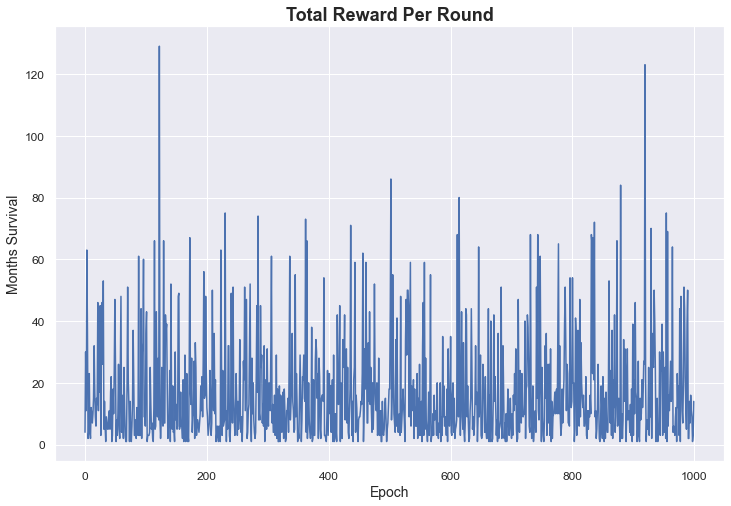

In [302]:
plt.figure(figsize=(12,8))
plt.rcParams["font.family"] = "Arial"
plt.plot(reward_hist)
plt.title('Total Reward Per Round', fontsize=18, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Months Survival', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

## Scratch/notes

Notes
* Add in "remission" as a state (i.e. no treatment)
  - Calculate similar to probability of death: probability that a no-treatment period follows a treatment
  - Then need to calculate probability following "remission" for each:
    - Death
    - remission, i.e. no treatment
    - More treatment i.e. "progression/recurrence" 
  - No-treatment ("[]") will not be in the action set
    - Unless already in the no-treatment state
    - Importantly, this means that the agent cannot decide to take a patient off of treatement. Not being on chemo is not a choice made by the AI "doctor", but rather, is a result of the previous treatment. Agent can, however, choose not to add drugs if already achieved remission (i.e. in the no-treatment state) 

* "Grid world" verion of action space
  - 56 dimensional object with up to 5 drugs activated at once
  - Action set is [Start drug {n}, Stop drug {n}, Do nothing]
    - Cannot [Stop drug {n}] if resulting state is no treatment
    - Cannot [Start drug {n}] if resulting len(combo) > 5
    - Cannot start a drug that is already in the combo
  - \> 4mm possible combinations, only 127 drug combos in data - is this necessary? 

* Rewards
  - I think in the final version this should be a probability distribution returning a number of days of survival/until treatment failure after each action
  - For starters, just try to get the average days survived when therapy doesn't result in death.
  - Also need to think of something for when patients don't die
    - Maybe just probability of death and a final non-death stop state?
    - Death vs. no death in the end doesn't matter unless the no deaths get a final reward

* Bellman action value equation: Q(s,a) = r + γ(max(Q(s’,a’))
  - "This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in"

* Replay memory?

Intermittant reward matrix for each patient

In [303]:
# fix because including no drug periods and using df

# tcga_rewards = {}
# for barcode in tcga_lines_keys:
#     rewards = []
#     for line in range(len(tcga_drug_lines[barcode])):
#         try:
#             rewards.append(tcga_drug_lines[barcode][line+1][0] - tcga_drug_lines[barcode][line][0])
#         except:
#             rewards.append(tcga_ov_1_keep.loc[tcga_ov_1_keep['bcr_patient_barcode'] == barcode, 'total_days_overall_survival'].iloc[0] - tcga_drug_lines[barcode][line][0])

#     tcga_rewards[barcode] = rewards

# tcga_rewards

In [304]:
# negs = []
# for barcode in tcga_rewards:
#     if tcga_rewards[barcode][-1] < 0:
#         negs.append(barcode)

# negs

In [305]:
# Add in final state for each patient: [time, 'death']
# Figure out what to do with patients where overall survival is < the end of the last therapy line

In [306]:
# define transition matrix
# def transition(state, action): 
#     if state,action = (living, drug A): 
#         then return 1 if np.random() < 0.8 …. 
        
#     if state, action = (living, drug B), return 1 
    
#     if ..
